# A/B test monitoring

## Initial setup
This first section just ensures that the connection to DWH works correctly.

In [37]:
import pathlib
import yaml
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats


In [38]:
CREDS_FILEPATH = pathlib.Path.home() / ".superhog-dwh" / "credentials.yml"
print(CREDS_FILEPATH)

/home/joaquin/.superhog-dwh/credentials.yml


In [39]:
# Prepare connection to DWH
# Function to read credentials from the YAML file
def read_credentials(yaml_path: str, env: str = "prd"):
    with open(yaml_path, "r") as file:
        credentials = yaml.safe_load(file)
    return credentials["envs"][env]
# Function to create a PostgreSQL connection string
def create_postgres_engine(creds: dict):
    user = creds["user"]
    password = creds["password"]
    host = creds["host"]
    port = creds["port"]
    database = creds["database"]
    # Create the connection string for SQLAlchemy
    connection_string = f"postgresql://{user}:{password}@{host}:{port}/{database}"
    engine = create_engine(connection_string)
    return engine
# Function to execute a query and return the result as a pandas DataFrame
def query_to_dataframe(engine, query: str):
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)
    return df
dwh_creds = read_credentials(yaml_path=CREDS_FILEPATH, env="prd")
dwh_pg_engine = create_postgres_engine(creds=dwh_creds)

In [40]:
# Silly query to test things out
test_df = query_to_dataframe(engine=dwh_pg_engine, query="SELECT 1;")
print(test_df.head())

   ?column?
0         1


## A/B test configuration
In this section we configure the parameters for the A/B test. Likely you do NOT need to change anything else than this, unless of course you want to create new metrics and so on.

The parameters to be specified are:
* **ab_test_name**: this should be the name of the feature flag corresponding to the A/B test. If you don't know the name, ask Guest Squad
* **var_A** and **var_B**: these correspond to the name of the variants. At this moment, we can only handle univariant testing (though updating the code to include multivariant testing should not be extremely difficult). In general, choose var_A to be the Control group.

In [ ]:
# A/B test name to measure
#ab_test_name = "AAVariantTest"
ab_test_name = "WelcomePageDestinationContext"

# Define the variations in which we want to run the tests
var_A = 'GenericImageAndCopy' # Ideally, this should be the control group
var_B = 'ContextSpecificImageAndCopy' # Ideally, this should be the study group

variations = [var_A, var_B]


## Data Extraction
In this section we extract the data from the Guest Journey monitoring within DWH by configuring which A/B test we want to measure. Here we already handle the basic aggregations that will be needed in the future, directly in SQL.

In [ ]:
# Query to extract data
data_extraction_query = """
select 
	ab_test_name,
	variation,
	max(first_appearance_date_utc) as last_update,
    
    -- SIMPLE COUNTS --
	count(id_verification_request) as guest_journeys_count,
	count(verification_started_date_utc) as guest_journey_started_count,
	count(verification_completed_date_utc) as guest_journey_completed_count,
	count(experience_rating) as guest_journey_with_responses_count,
	count(last_payment_paid_date_utc) as guest_journey_with_payment_count,
	count(guest_revenue_without_taxes_in_gbp) as guest_revenue_count,
	count(deposit_fees_without_taxes_in_gbp) as deposit_count,
	count(waiver_fees_without_taxes_in_gbp) as waiver_count,
	count(check_in_cover_fees_without_taxes_in_gbp) as check_in_cover_count,
    
    -- SIMPLE SUMS --
	sum(guest_revenue_without_taxes_in_gbp) as guest_revenue_sum,
	sum(deposit_fees_without_taxes_in_gbp) as deposit_sum,
	sum(waiver_fees_without_taxes_in_gbp) as waiver_sum,
	sum(check_in_cover_fees_without_taxes_in_gbp) as check_in_cover_sum,
    
    -- AVGs/SDVs PER GUEST JOURNEY (ANY GJ APPEARING IN THE A/B TEST) --
    -- NOTE THE COALESCE HERE. THIS IS IMPORTANT FOR THE T-TEST COMPUTATION --
    avg(coalesce(guest_revenue_without_taxes_in_gbp,0)) as guest_revenue_avg_per_guest_journey,
    stddev(coalesce(guest_revenue_without_taxes_in_gbp,0)) as guest_revenue_sdv_per_guest_journey,
    avg(coalesce(deposit_fees_without_taxes_in_gbp,0)) as deposit_avg_per_guest_journey,
    stddev(coalesce(deposit_fees_without_taxes_in_gbp,0)) as deposit_sdv_per_guest_journey,
    avg(coalesce(waiver_fees_without_taxes_in_gbp,0)) as waiver_avg_per_guest_journey,
    stddev(coalesce(waiver_fees_without_taxes_in_gbp,0)) as waiver_sdv_per_guest_journey,
    avg(coalesce(check_in_cover_fees_without_taxes_in_gbp,0)) as check_in_cover_avg_per_guest_journey,
    stddev(coalesce(check_in_cover_fees_without_taxes_in_gbp,0)) as check_in_cover_sdv_per_guest_journey,
    
    -- AVGs/SDVs PER GUEST JOURNEY WITH CSAT RESPONSE --
    -- NOTE THAT THERE'S NO COALESCE HERE. THIS IS IMPORTANT FOR THE T-TEST COMPUTATION --
    avg(experience_rating) as csat_avg_per_guest_journey_with_response,
    stddev(experience_rating) as csat_sdv_per_guest_journey_with_response
    
from
	intermediate.int_core__ab_test_monitoring_guest_journey
where
	ab_test_name = '{}'
    and first_appearance_at_utc >= '2025-04-23 12:50:00'
group by
	1,2
""".format(ab_test_name)

# Retrieve Data from Query
df = query_to_dataframe(engine=dwh_pg_engine, query=data_extraction_query)
print(df.head())

           ab_test_name         variation last_update  guest_journeys_count  \
0  ShowNewIllustrations  NewIllustrations  2025-04-16                 20916   
1  ShowNewIllustrations  OldIllustrations  2025-04-16                 21018   

   guest_journey_started_count  guest_journey_completed_count  \
0                        20916                          16155   
1                        21018                          16187   

   guest_journey_with_responses_count  guest_journey_with_payment_count  \
0                                5820                              8677   
1                                6084                              8580   

   guest_revenue_count  deposit_count  ...  \
0                 8677           1439  ...   
1                 8580           1393  ...   

   guest_revenue_avg_per_guest_journey  guest_revenue_sdv_per_guest_journey  \
0                            10.703579                            16.931697   
1                            10.488324     

## Check A/B test Allocation to Variation

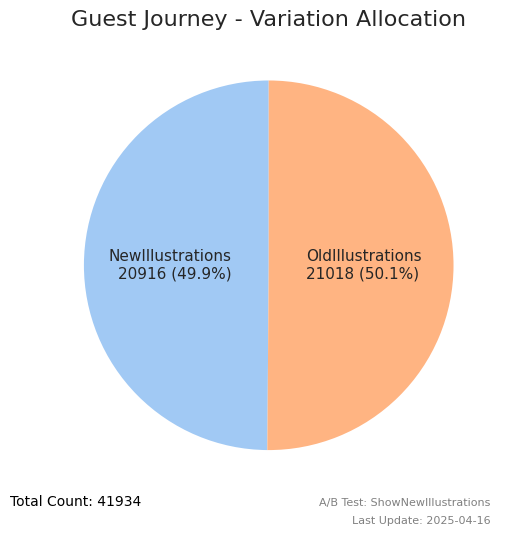

In [43]:
# Ensure Seaborn styling
sns.set_theme(style="whitegrid")

# Calculate the total guest_journeys_count per variation
grouped_data = df.groupby('variation')['guest_journeys_count'].sum()

# Find the total count and other metadata
total_count = grouped_data.sum()
ab_test_name = df['ab_test_name'].iloc[0]  # Assuming all rows are for the same A/B test
last_update = df['last_update'].max()

# Create a pie chart using Seaborn styling
plt.figure(figsize=(8, 6))
colors = sns.color_palette("pastel")  # Seaborn pastel colors

# Pie chart with labels inside each sector
plt.pie(
    grouped_data, 
    labels=[f"{var}\n{count} ({count/total_count:.1%})" for var, count in grouped_data.items()],
    autopct=None, 
    colors=colors, 
    startangle=90,
    wedgeprops={'edgecolor': 'none'},  # Remove edges around sectors
    pctdistance=0.70,  # Places the labels closer to the center (inside)
    labeldistance=0.2  # Ensure labels are positioned inside the sectors
)

# Add title
plt.title("Guest Journey - Variation Allocation", fontsize=16)

# Add total count to the bottom-left
plt.text(-1.4, -1.3, f"Total Count: {total_count}", fontsize=10, ha='left', color='black')

# Add A/B test name and last update to the bottom-right
plt.text(1.2, -1.3, f"A/B Test: {ab_test_name}", fontsize=8, ha='right', color='gray')
plt.text(1.2, -1.4, f"Last Update: {last_update}", fontsize=8, ha='right', color='gray')

plt.show()

## Statistical Analysis
In this section we compute the metrics needed for monitoring as well as check if there's any statistical difference between the different variations.

### Z-test for Proportion Metrics (Rates)
This section defines the functions used to compute Z-test Proportion analysis

In [44]:
# Generalized function to calculate Z-test for any metric
def calculate_z_test(df, metric_name, variation_a, variation_b, success_counts, total_counts):

    # Aggregate the success counts (numerator) and total counts (denominator) for each variation
    success_a = df[df['variation'] == variation_a][success_counts].sum()
    success_b = df[df['variation'] == variation_b][success_counts].sum()

    total_a = df[df['variation'] == variation_a][total_counts].sum()
    total_b = df[df['variation'] == variation_b][total_counts].sum()

    # Calculate conversion rates for each variation
    value_A = success_a / total_a if total_a != 0 else 0
    value_B = success_b / total_b if total_b != 0 else 0

    # Absolute difference (B - A)
    abs_diff = value_B - value_A

    # Relative difference (B - A) / A
    rel_diff = (value_B - value_A) / value_A if value_A != 0 else 0

    # Perform the z-test for proportions
    count = [success_a, success_b]  # Success counts for A and B
    nobs = [total_a, total_b]  # Total counts for A and B
    
    # Calculate z-stat and p-value
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # Flag for significance at 95% level (p-value < 0.05)
    is_significant = p_value < 0.05

    # Return the result as a dictionary
    return {
        'metric': metric_name,
        'variation_A_name': variation_a,
        'variation_B_name': variation_b,
        'variation_A_value': value_A,
        'variation_B_value': value_B,
        'absolute_difference': abs_diff,
        'relative_difference': rel_diff,
        'statistic': z_stat,
        'p_value': p_value,
        'is_significant_95': is_significant
    }

# Function to run Z-tests for multiple metrics and aggregate results into a DataFrame
def run_z_tests(df, z_stat_metric_definition, variations):
    results = []
    
    # Loop over all metrics in z_stat_metric_definition
    for metric_name, metric_definition in z_stat_metric_definition.items():
        success_counts = metric_definition['success_counts']
        total_counts = metric_definition['total_counts']
        
        # Run the Z-test for each metric
        result = calculate_z_test(df, metric_name, variation_a=variations[0], variation_b=variations[1], 
                                  success_counts=success_counts, total_counts=total_counts)
        results.append(result)
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    return results_df

### T-test for non-proportion metrics
This section defines the functions used to compute T-tests for metrics outside of the proportion scope, mostly Revenue-related metrics.

In [45]:

# Generalized function to calculate T-test for revenue-related metrics
def calculate_t_test(df, metric_name, variation_a, variation_b, metric_avg_column, metric_sdv_column, total_counts):
    # Aggregate the avgs and standard deviations for each variation
    mean_a = df[df['variation'] == variation_a][metric_avg_column].mean() # Assuming the avg is calculated for each group
    mean_b = df[df['variation'] == variation_b][metric_avg_column].mean() # Assuming the avg is calculated for each group
    
    sdv_a = df[df['variation'] == variation_a][metric_sdv_column].mean()  # Assuming the stddev is calculated for each group
    sdv_b = df[df['variation'] == variation_b][metric_sdv_column].mean()  # Assuming the stddev is calculated for each group
    
    total_a = df[df['variation'] == variation_a][total_counts].sum()
    total_b = df[df['variation'] == variation_b][total_counts].sum()

    # Absolute difference (B - A)
    abs_diff = mean_b - mean_a

    # Relative difference (B - A) / A
    rel_diff = (mean_b - mean_a) / mean_a if mean_a != 0 else 0

    # Calculate the T-statistic and p-value using the formula for two-sample T-test
    se_a = sdv_a / (total_a ** 0.5) if total_a != 0 else 0
    se_b = sdv_b / (total_b ** 0.5) if total_b != 0 else 0

    # Standard error of the difference between the means
    se_diff = (se_a ** 2 + se_b ** 2) ** 0.5
    
    # T-statistic formula
    if se_diff != 0:
        t_stat = (mean_a - mean_b) / se_diff
    else:
        t_stat = 0
    
    # Degrees of freedom (for independent samples)
    df_degrees = min(total_a - 1, total_b - 1)  # Using the smaller of the two sample sizes minus 1
    
    # P-value from the T-distribution
    p_value = stats.t.sf(abs(t_stat), df_degrees) * 2  # Two-tailed test
    
    # Flag for significance at 95% level (p-value < 0.05)
    is_significant = p_value < 0.05

    # Return the result as a dictionary
    return {
        'metric': metric_name,
        'variation_A_name': variation_a,
        'variation_B_name': variation_b,
        'variation_A_value': mean_a,
        'variation_B_value': mean_b,
        'absolute_difference': abs_diff,
        'relative_difference': rel_diff,
        'statistic': t_stat,
        'p_value': p_value,
        'is_significant_95': is_significant
    }

# Function to run T-tests for multiple revenue metrics and aggregate results into a DataFrame
def run_t_tests(df, t_stat_metric_definition, variations):
    results = []
    
    # Loop over all metrics in t_stat_metric_definition
    for metric_name, metric_definition in t_stat_metric_definition.items():
        metric_avg_column = metric_definition['metric_avg_column']
        metric_sdv_column = metric_definition['metric_sdv_column']
        total_counts = metric_definition['total_counts']
        
        # Run the T-test for each metric
        result = calculate_t_test(df, metric_name, variation_a=variations[0], variation_b=variations[1], 
                                  metric_avg_column=metric_avg_column, metric_sdv_column=metric_sdv_column, 
                                  total_counts=total_counts)
        results.append(result)
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    return results_df

### Specify the metric definition for Z-stat and T-stat tests

In [46]:
# Define the Z-test metric definitions (with both success_counts and total_counts)
z_stat_metric_definition = {
    'conversion_rate': {
        'success_counts': 'guest_journey_completed_count',
        'total_counts': 'guest_journeys_count'
    },
    'payment_rate': {
        'success_counts': 'guest_journey_with_payment_count',
        'total_counts': 'guest_journeys_count'
    },
    'waiver_payment_rate': {
        'success_counts': 'waiver_count',
        'total_counts': 'guest_journeys_count'
    },
    'deposit_payment_rate': {
        'success_counts': 'deposit_count',
        'total_counts': 'guest_journeys_count'
    },
    'CIH_payment_rate': {
        'success_counts': 'check_in_cover_count',
        'total_counts': 'guest_journeys_count'
    }
}

# Define the T-test metric definitions (with both metric_avg_column and metric_sdv_column)
t_stat_metric_definition = {
    'avg_guest_revenue_per_gj': {
        'metric_avg_column': 'guest_revenue_avg_per_guest_journey',
        'metric_sdv_column': 'guest_revenue_sdv_per_guest_journey',
        'total_counts': 'guest_journeys_count'
    },
    'avg_waiver_revenue_per_gj': {
        'metric_avg_column': 'waiver_avg_per_guest_journey',
        'metric_sdv_column': 'waiver_sdv_per_guest_journey',
        'total_counts': 'guest_journeys_count'
    },
    'avg_deposit_revenue_per_gj': {
        'metric_avg_column': 'deposit_avg_per_guest_journey',
        'metric_sdv_column': 'deposit_sdv_per_guest_journey',
        'total_counts': 'guest_journeys_count'
    },
    'avg_CIH_revenue_per_gj': {
        'metric_avg_column': 'check_in_cover_avg_per_guest_journey',
        'metric_sdv_column': 'check_in_cover_sdv_per_guest_journey',
        'total_counts': 'guest_journeys_count'
    },
    'avg_csat_per_gj_with_response': {
        'metric_avg_column': 'csat_avg_per_guest_journey_with_response',
        'metric_sdv_column': 'csat_sdv_per_guest_journey_with_response',
        'total_counts': 'guest_journey_with_responses_count'
    }

}

# Define the metrics that will be the main ones for this A/B test:
main_metrics = ['avg_guest_revenue_per_gj', 'conversion_rate', 'payment_rate']

### Run the computation of the metrics and statistical significance

In [47]:
# Call the function to calculate the Z-test for each metric and aggregate the results
z_test_results_df = run_z_tests(df, z_stat_metric_definition=z_stat_metric_definition, variations=variations)

# Call the function to calculate the T-test for each metric and aggregate the results
t_test_results_df = run_t_tests(df, t_stat_metric_definition=t_stat_metric_definition, variations=variations)

# Add a new column to identify whether it's from Z-test or T-test
z_test_results_df['test_type'] = 'Z-test'
t_test_results_df['test_type'] = 'T-test'

# Combine the dataframes after adding the 'test_type' column
combined_results_df = pd.concat([z_test_results_df, t_test_results_df], ignore_index=True)

# Print the main aggregated DataFrame
print(combined_results_df[['metric','relative_difference','p_value']])

                          metric  relative_difference   p_value
0                conversion_rate             0.002890  0.587414
1                   payment_rate             0.016237  0.167865
2            waiver_payment_rate             0.011461  0.398951
3           deposit_payment_rate             0.038060  0.303386
4               CIH_payment_rate             0.100579  0.173649
5       avg_guest_revenue_per_gj             0.020523  0.193648
6      avg_waiver_revenue_per_gj             0.017515  0.295568
7     avg_deposit_revenue_per_gj             0.056502  0.217435
8         avg_CIH_revenue_per_gj             0.103937  0.162819
9  avg_csat_per_gj_with_response            -0.005045  0.306604


## Results


In [48]:
print('\n{} results (last updated at {})\n'.format(ab_test_name, last_update))

# Get main volume indicators per variation
grouped_data = df.groupby('variation')[["guest_journeys_count","guest_revenue_sum"]].sum()

# Find the totals over any variation
total_count = grouped_data.sum()

# Print overall indicators for volumes
print('Total Guest Journeys affected by this A/B test: {} - Total Guest Revenue: {} GBP.'.format(int(total_count.loc["guest_journeys_count"]), 
                                                                                                int(total_count.loc["guest_revenue_sum"])))
for var in variations:
    print('  Variation {}: Guest Journeys {} ({}%) - Guest Revenue: {} GBP ({}%).'.format(
        var, 
        int(grouped_data.loc[var,'guest_journeys_count']), 
        round(100*(grouped_data.loc[var,'guest_journeys_count']/total_count.loc["guest_journeys_count"]),1),
        int(grouped_data.loc[var,'guest_revenue_sum']),
        round(100*(grouped_data.loc[var,'guest_revenue_sum']/total_count.loc["guest_revenue_sum"]),1)
    ))

# Split results whether the metrics are main metrics or not
main_metrics_rows = combined_results_df[combined_results_df['metric'].isin(main_metrics)]
other_metrics_rows = combined_results_df[~combined_results_df['metric'].isin(main_metrics)]

def print_metrics(df, header=None):
    if header:
        print(f'\n{header}\n')

    for row in df.iterrows():
        metric = row[1]['metric'].upper().replace('_', ' ')
        if row[1]['test_type'] == 'Z-test':
            value_a = str(round(100 * row[1]['variation_A_value'], 1)) + '%'
            value_b = str(round(100 * row[1]['variation_B_value'], 1)) + '%'
            abs_diff = str(round(100 * row[1]['absolute_difference'], 1)) + '%'
        else:
            value_a = str(round(row[1]['variation_A_value'], 2))
            value_b = str(round(row[1]['variation_B_value'], 2))
            abs_diff = str(round(row[1]['absolute_difference'], 2))
        rel_diff = str(round(100 * row[1]['relative_difference'], 1)) + '%'
        stat_sign = row[1]['is_significant_95']

        if stat_sign:
            print(f"{metric} - SIGNIFICANT RESULT: {value_b} vs. {value_a} ({abs_diff} ppts.| {rel_diff}).")
        else:
            print(f"{metric} (not significant): {value_b} vs. {value_a} ({abs_diff} ppts.| {rel_diff}).")

# Print main metrics
print_metrics(main_metrics_rows, header="Main Metrics - Comparing {} vs. {}.".format(var_B, var_A))

# Print other metrics
print_metrics(other_metrics_rows, header="Other Metrics")



ShowNewIllustrations results (last updated at 2025-04-16)

Total Guest Journeys affected by this A/B test: 41934 - Total Guest Revenue: 444319 GBP.
  Variation OldIllustrations: Guest Journeys 21018 (50.1%) - Guest Revenue: 220443 GBP (49.6%).
  Variation NewIllustrations: Guest Journeys 20916 (49.9%) - Guest Revenue: 223876 GBP (50.4%).

Main Metrics - Comparing NewIllustrations vs. OldIllustrations.

CONVERSION RATE (not significant): 77.2% vs. 77.0% (0.2% ppts.| 0.3%).
PAYMENT RATE (not significant): 41.5% vs. 40.8% (0.7% ppts.| 1.6%).
AVG GUEST REVENUE PER GJ (not significant): 10.7 vs. 10.49 (0.22 ppts.| 2.1%).

Other Metrics

WAIVER PAYMENT RATE (not significant): 34.5% vs. 34.1% (0.4% ppts.| 1.1%).
DEPOSIT PAYMENT RATE (not significant): 6.9% vs. 6.6% (0.3% ppts.| 3.8%).
CIH PAYMENT RATE (not significant): 2.0% vs. 1.8% (0.2% ppts.| 10.1%).
AVG WAIVER REVENUE PER GJ (not significant): 10.04 vs. 9.87 (0.17 ppts.| 1.8%).
AVG DEPOSIT REVENUE PER GJ (not significant): 0.49 vs. 0.46